In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In [2]:
# simulation time
sim_time = 100
time_step = 2

In [3]:
# giu' su sinistra destra
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [0,8,0,0], [0,8,0,0]
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [8,0,0,12], [8,0,12,0]
vascular = [8,0,0,0]

P_out = np.zeros((22,12,4))

# 22 rows, 12 columns. The first is the upmost cell in the tip

# cinta esterna della radice (muraria)
P_out[0,:,:]=[0,0,0,0]
P_out[-1,:,:]=[0,0,0,0]
P_out[:,0,:]=[0,0,0,0]
P_out[:,-1,:]=[0,0,0,0]

# in futuro aggiungeremo un flusso di auxina dallo shoot

# defining colummellas
P_out[1:4,1:11] = colummella

# defining epidermal
P_out[4:21,1:3] = epidermal_l
P_out[4:21,9:11] = epidermal_r

# defining border
P_out[4:21,3] = border_l
P_out[4:21,8] = border_r

# defining vascular
P_out[4:21,4:8] = vascular

# defining QC in position [4,4:8] same PIN settings as vascular
#defining directions 0 is down, 1 is up, 2 is left, 3 is right

directions = [0, 1, 2, 3]

In [4]:
def update_2D(cells, counter, source=(4,4), source_val=10, D=0.5, T=0.5, P_out=P_out, decay=0.000005 ):
    """
    updates vector of cells following equation (1)
    
    WORKS ONLY FOR 1D MODELS
    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[-1,0], [1,0], [0,-1], [0,1]])
    updated_cells = np.zeros((len(cells),12))
    cells_flux = np.zeros((2,len(cells),12))
    for i, value in enumerate(cells[1:20], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros((2,cells.shape[1]))
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k] for k in tuple(map(tuple, v + [i,j]))]
            
            diffusion_in = sum(neighbours)*(D/(value[j]+1))
            diffusion_out = -(1/2.5)*sum([1/(i) if i != 0 else 0 for i in neighbours])*D*value[j]
            aux_decay = -decay*value[j]

            transport_in = T*np.dot(P_out[i,j,:],neighbours)*(D/(value[j]+1))
            transport_out = -T*sum(P_out[i,j,:])*value[j]*sum([1/(i) if i != 0 else 0 for i in neighbours])
            
            
            
            
            #diagnostics
            
            if (P_out[i,j,:] == colummella).all():
                cell_type = 'colummella'
            elif (P_out[i,j,:] == epidermal_l).all():
                cell_type = 'epidermal'
            elif (P_out[i,j,:] == vascular).all():
                cell_type = 'vascular/QC'
            elif (P_out[i,j,:] == border_l).all():
                cell_type = 'border l'
            elif (P_out[i,j,:] == border_r).all():
                cell_type = 'border r'
            
            
            print('Total Diffusion/Transport ratio: '+ str((diffusion_in-diffusion_out)/(transport_in-transport_out)), ' Diffusion: ' + str((diffusion_in-diffusion_out)),  'Transport: ' + str(transport_in-transport_out), ' Value: '+str(value[j]),
                 'Cell type:'+ cell_type)
           


            print('')
            print('Out_Transport_Components:')
            print('Pin sum:' + str(sum(P_out[i,j,:])), ' Old auxin amount:' + str(value[j]), 'Inverse of Neigh Sum: ' + str(sum([1/(i) if i != 0 else 0 for i in neighbours])),  'Transport out: '+ str(transport_out))
            
            
            
            transport_out_down = -T*P_out[i,j,0]*value[j] ##divide the output of the transport depending on the direction
            transport_out_up =  -T*P_out[i,j,1]*value[j]
            transport_out_left =  -T*P_out[i,j,2]*value[j]
            transport_out_right = -T*P_out[i,j,3]*value[j]
            
            x_coord = (transport_out_left-transport_out_right)
            y_coord = (transport_out_up-transport_out_down)
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = value[j] + transport_in + transport_out + diffusion_in + diffusion_out + aux_decay + 16*24*0.0005
            step_direction_flux[:,j] = (x_coord, y_coord)
            
            
            print('')
            print(f'Step: {step[j]}')
            print('')
            print('Next cell')
            print('')
            
            

            #if step[j] <= 0:
            #    step[j] = 0

        updated_cells[i,:] = [0] + step + [0]
        cells_flux[:,i,:] = [0] + step_direction_flux + [0]
    updated_cells[source[0], source[1]:source[1]+4] += source_val*16*24
    print('')
    print('')
    print('')
    print('')
    print('')
    print('')
    print('')
    
    print(f'Iteration n: {counter}')
    return updated_cells,cells_flux

In [5]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1,:]=0
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
cells_a[4,4:8] = 40
# fig= plt.figure(figsize=(12,5)) #common canvas for any figure
# plt.ion()
# plt.title('Time: Beginning')
# plt.axis('off')
# plt.imshow(cells_a.T, cmap="jet")
cells_out = cells_a

times = np.arange(0, sim_time, time_step)   
roun = 0
for t in times:
    roun += 1 
    cells_out, cells_fluxes = update_2D(cells_out, T=1, D=0, counter=roun)
    #print(cells_fluxes)
#     plt.imshow(cells_out.T, cmap="jet")
    
# ### normalized arrows

#     U = cells_fluxes[1,:,:].T
#     V = cells_fluxes[0,:,:].T
#     U_norm = U / np.sqrt(U**2 + V**2);
#     V_norm = V / np.sqrt(U**2 + V**2);
    
#     plt.quiver(U_norm, V_norm, pivot='mid')

#     plt.title(f"Timestep: {str(t)}")
#     plt.axis('off')
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     if t != times[-1]:
#         plt.clf() ##to avoid the clearance of the plot


Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 80.0  Value: 20.0 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.1 Transport out: -80.0

Step: -59.8081

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 120.00000000000001  Value: 20.0 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.15000000000000002 Transport out: -120.00000000000001

Step: -99.80810000000002

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 120.00000000000001  Value: 20.0 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.15000000000000002 Transport out: -120.00000000000001

Step: -99.80810000000002

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 120.00000000000001  Value: 20.0 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin a

Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.15000000000000002 Transport out: -24.000000000000004

Step: -3.808100000000003

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 24.000000000000004  Value: 20.0 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.15000000000000002 Transport out: -24.000000000000004

Step: -3.808100000000003

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 32.0  Value: 20.0 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -32.0

Step: -11.8081

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 80.0  Value: 20.0 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:20.0 Inverse of Neigh Sum: 0.2 Transport out: -80.0

Step: -59.8081

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 32.0  Value: 20

Pin sum:8.0  Old auxin amount:-11.8081 Inverse of Neigh Sum: -0.3387505187117318 Transport out: -32.0

Step: -43.6160409595

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 32.0  Value: -11.8081 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-11.8081 Inverse of Neigh Sum: -0.3387505187117318 Transport out: -32.0

Step: -43.6160409595

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 25.57946498885602  Value: -11.8081 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-11.8081 Inverse of Neigh Sum: -0.27078303229198625 Transport out: -25.57946498885602

Step: -37.19550594835602

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 242.60024898163127  Value: -59.8081 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-59.8081 Inverse of Neigh Sum: -0.20281554587224077 Transport out: -242.60024898163127

Step: -302.21604994113125


Total Diffusion/Transport ratio: -0.0  Diffusion: 0.0 Transport: -5601.125745582689  Value: 12444.143071141654 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:12444.143071141654 Inverse of Neigh Sum: -0.05626267025340489 Transport out: 5601.125745582689

Step: 18045.398596008985

Next cell

Total Diffusion/Transport ratio: -0.0  Diffusion: 0.0 Transport: -3669.7757496343224  Value: 11838.612303446287 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:11838.612303446287 Inverse of Neigh Sum: -0.03874795093769172 Transport out: 3669.7757496343224

Step: 15508.52086001909

Next cell

Total Diffusion/Transport ratio: -0.0  Diffusion: 0.0 Transport: -3669.7757496343224  Value: 11838.612303446287 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:11838.612303446287 Inverse of Neigh Sum: -0.03874795093769172 Transport out: 3669.7757496343224

Step: 15508.52086001909

Next cell

Total Diffusion/Transport rat

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 33.380927044263586  Value: -43.6160409595 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-43.6160409595 Inverse of Neigh Sum: -0.09566700206484724 Transport out: -33.380927044263586

Step: -76.80474992355879

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 23.806960482419267  Value: -37.19550594835602 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-37.19550594835602 Inverse of Neigh Sum: -0.08000617237023863 Transport out: -23.806960482419267

Step: -60.81028045324555

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 314.42954446254714  Value: -302.21604994113125 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-302.21604994113125 Inverse of Neigh Sum: -0.05202065617027868 Transport out: -314.42954446254714

Step: -616.4520833234287

Next cell

Total Diffusion/Transport ratio: 0.0

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 34.104179668450726  Value: -76.80474992355879 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-76.80474992355879 Inverse of Neigh Sum: -0.05550467207821372 Transport out: -34.104179668450726

Step: -110.7165455682599

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 34.104179668450726  Value: -76.80474992355879 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-76.80474992355879 Inverse of Neigh Sum: -0.05550467207821372 Transport out: -34.104179668450726

Step: -110.7165455682599

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 23.123177200920722  Value: -60.81028045324555 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-60.81028045324555 Inverse of Neigh Sum: -0.04753138989940022 Transport out: -23.123177200920722

Step: -83.741153602764

Next cell

Total Diffusion/Transport rati

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 34.705504499259796  Value: -110.7887643971782 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-110.7887643971782 Inverse of Neigh Sum: -0.03915729258298298 Transport out: -34.705504499259796

Step: -145.301714952616

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 22.98158862880497  Value: -83.8469888592328 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-83.8469888592328 Inverse of Neigh Sum: -0.03426120147765205 Transport out: -22.98158862880497

Step: -106.63615825309347

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 436.11258688292105  Value: -994.9312871351855 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-994.9312871351855 Inverse of Neigh Sum: -0.021916718899184874 Transport out: -436.11258688292105

Step: -1430.846899361671

Next cell

Total Diffusion/Transport ratio: 

Pin sum:8.0  Old auxin amount:-165.9758660729565 Inverse of Neigh Sum: -0.029337471635358926 Transport out: -38.954498104555945

Step: -204.73753429818208

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 38.95449810455596  Value: -165.97586607295653 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-165.97586607295653 Inverse of Neigh Sum: -0.02933747163535893 Transport out: -38.95449810455596

Step: -204.73753429818214

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 44.00758309785782  Value: -147.55405522508363 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-147.55405522508363 Inverse of Neigh Sum: -0.03728089938864037 Transport out: -44.00758309785782

Step: -191.36890055266534

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 358.93848712996214  Value: -1272.6690598599198 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin am

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 489.85961971999217  Value: -1431.213488197499 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-1431.213488197499 Inverse of Neigh Sum: -0.017113436386661362 Transport out: -489.85961971999217

Step: -1920.8739518500502

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 32.658965816902885  Value: -158.57192384515469 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-158.57192384515469 Inverse of Neigh Sum: -0.025744599851732212 Transport out: -32.658965816902885

Step: -191.03809680243833

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.057669032505167  Value: -80.42904810140652 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-80.42904810140652 Inverse of Neigh Sum: -0.03117292431338996 Transport out: -20.057669032505167

Step: -100.29431498867119

Next cell

Total Diffusion/Transport r

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.200759351226605  Value: -100.29431498867119 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-100.29431498867119 Inverse of Neigh Sum: -0.02517684994596702 Transport out: -20.200759351226605

Step: -120.30257286832286

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.199971279755385  Value: -100.29431498867119 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-100.29431498867119 Inverse of Neigh Sum: -0.025175867747385637 Transport out: -20.199971279755385

Step: -120.30178479685163

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 32.03382935183835  Value: -191.03809680243833 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-191.03809680243833 Inverse of Neigh Sum: -0.020960367256593636 Transport out: -32.03382935183835

Step: -222.87897096379268

Next cell

Total Diffusion/Transport


Step: -279.15224362961436

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 36.8379355691829  Value: -242.50752059803455 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-242.50752059803455 Inverse of Neigh Sum: -0.018988037710304242 Transport out: -36.8379355691829

Step: -279.1522436296144

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 54.66199689535484  Value: -240.24023421655545 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-240.24023421655545 Inverse of Neigh Sum: -0.028441320972740276 Transport out: -54.66199689535484

Step: -294.7090299107392

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 364.2662471260674  Value: -1995.064572930431 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-1995.064572930431 Inverse of Neigh Sum: -0.009129184390032512 Transport out: -364.2662471260674

Step: -2359.1288447336337

Ne

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 4859.974951019829  Value: -10945.759954039588 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-10945.759954039588 Inverse of Neigh Sum: -0.022200262802338503 Transport out: -4859.974951019829

Step: -15805.488176259647

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 18.83711763073048  Value: -226.72131105459425 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-226.72131105459425 Inverse of Neigh Sum: -0.010385612595872451 Transport out: -18.83711763073048

Step: -245.36529507876946

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 79.2146798918626  Value: -273.15949059673994 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-273.15949059673994 Inverse of Neigh Sum: -0.03624928046560429 Transport out: -79.2146798918626

Step: -352.18080469114955

Next cell

Total Diffusion/Transport ratio

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 81.96772408345895  Value: -279.83052069862373 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-279.83052069862373 Inverse of Neigh Sum: -0.036614896348162215 Transport out: -81.96772408345895

Step: -361.6048456294792

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 2.165730105395997  Value: -40.995258692292296 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-40.995258692292296 Inverse of Neigh Sum: -0.006603599338315634 Transport out: -2.165730105395997

Step: -42.96878382139483

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 76.35179990658546  Value: -330.03216113500145 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-330.03216113500145 Inverse of Neigh Sum: -0.028918318007253745 Transport out: -76.35179990658546

Step: -406.19031088078117

Next cell

Total Diffusion/Transport rati

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 30.821308691424026  Value: -285.18912404778047 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-285.18912404778047 Inverse of Neigh Sum: -0.01350915326554504 Transport out: -30.821308691424026

Step: -315.81700679358426

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.50599905177321  Value: -160.65317218125946 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-160.65317218125946 Inverse of Neigh Sum: -0.015955177521049035 Transport out: -20.50599905177321

Step: -180.96636796717178

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.51947342133387  Value: -160.66439382505743 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-160.66439382505743 Inverse of Neigh Sum: -0.01596454644742016 Transport out: -20.51947342133387

Step: -180.99106392442215

Next cell

Total Diffusion/Transport ra

Step: -201.35848889721484

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 30.541040946267433  Value: -315.81694496546163 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-315.81694496546163 Inverse of Neigh Sum: -0.012088110467603101 Transport out: -30.541040946267433

Step: -346.16440682700426

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 719.5819222513778  Value: -4357.919912484909 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-4357.919912484909 Inverse of Neigh Sum: -0.008256025084236441 Transport out: -719.5819222513778

Step: -5077.2880451367255

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.776766034539854  Value: -215.9503163354788 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-215.9503163354788 Inverse of Neigh Sum: -0.012605194567479616 Transport out: -21.776766034539854

Step: -237.53400261843697


Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 9.940815529584542  Value: -297.30521623308175 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-297.30521623308175 Inverse of Neigh Sum: -0.0008359099493389923 Transport out: -9.940815529584542

Step: -307.0525452365851

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 660.1726879113379  Value: -3255.9584118040148 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-3255.9584118040148 Inverse of Neigh Sum: -0.005068958232988907 Transport out: -660.1726879113379

Step: -3915.922819923294

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 65.55632214423879  Value: -956.887422563884 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-956.887422563884 Inverse of Neigh Sum: -0.001712749080988733 Transport out: -65.55632214423879

Step: -1022.24696027101

Next cell

Total Diffusion/Transport rat

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 760.8390667607872  Value: -5077.2820238582735 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-5077.2820238582735 Inverse of Neigh Sum: -0.007492582283056029 Transport out: -760.8390667607872

Step: -5837.903704208941

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 30.298586374202184  Value: -346.1644083207274 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-346.1644083207274 Inverse of Neigh Sum: -0.010940822354175279 Transport out: -30.298586374202184

Step: -376.2692638728879

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.65355915627554  Value: -201.35849186051271 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-201.35849186051271 Inverse of Neigh Sum: -0.012821385731885909 Transport out: -20.65355915627554

Step: -221.81904422432896

Next cell

Total Diffusion/Transport rati

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 11.915017415270864  Value: -180.49605640849248 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-180.49605640849248 Inverse of Neigh Sum: -0.008251577383708322 Transport out: -11.915017415270864

Step: -192.2181713434813

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 38.36845371980092  Value: -401.7898657719023 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-401.7898657719023 Inverse of Neigh Sum: -0.011936728931082236 Transport out: -38.36845371980092

Step: -439.9643105423744

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 330.5124786497511  Value: -3764.340622426735 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-3764.340622426735 Inverse of Neigh Sum: -0.00439004478872958 Transport out: -330.5124786497511

Step: -4094.642279373374

Next cell

Total Diffusion/Transport ratio: 0

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 47.10356397744769  Value: -378.0882692253304 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-378.0882692253304 Inverse of Neigh Sum: -0.015572938851673032 Transport out: -47.10356397744769

Step: -424.99794276143194

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 642.0459710924426  Value: -5153.875043862381 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-5153.875043862381 Inverse of Neigh Sum: -0.006228769281640218 Transport out: -642.0459710924426

Step: -5795.703245579604

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 13.169547603704139  Value: -300.72697494639357 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-300.72697494639357 Inverse of Neigh Sum: -0.00547404651929366 Transport out: -13.169547603704139

Step: -313.70301891522297

Next cell

Total Diffusion/Transport rati

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.829290517110447  Value: -242.45932235850057 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-242.45932235850057 Inverse of Neigh Sum: -0.010738549004063576 Transport out: -20.829290517110447

Step: -263.0954005789992

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.280814087934065  Value: -240.97529209673226 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-240.97529209673226 Inverse of Neigh Sum: -0.010520172997545815 Transport out: -20.280814087934065

Step: -261.0629013082059

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 30.079838517384342  Value: -406.5394009442405 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-406.5394009442405 Inverse of Neigh Sum: -0.00924874638458167 Transport out: -30.079838517384342

Step: -436.42520676462016

Next cell

Total Diffusion/Transport r

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.51668046620064  Value: -301.8559018684303 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-301.8559018684303 Inverse of Neigh Sum: -0.008910162238429208 Transport out: -21.51668046620064

Step: -323.1790730551216

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 878.6945405504332  Value: -7478.801073322854 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-7478.801073322854 Inverse of Neigh Sum: -0.0058745682090995 Transport out: -878.6945405504332

Step: -8357.26621986792

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 29.728335248934677  Value: -435.86454524030523 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-435.86454524030523 Inverse of Neigh Sum: -0.008525680619578885 Transport out: -29.728335248934677

Step: -465.3987011665137

Next cell

Total Diffusion/Transport ratio: 0


Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 27.768622040929323  Value: -502.7231850527102 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-502.7231850527102 Inverse of Neigh Sum: -0.006904550771320055 Transport out: -27.768622040929323

Step: -530.2972934777142

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 126.0408529923591  Value: -889.7035982476689 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-889.7035982476689 Inverse of Neigh Sum: -0.01770826447715355 Transport out: -126.0408529923591

Step: -1015.5480027220367

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 298.6655675403737  Value: -4724.081248031701 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-4724.081248031701 Inverse of Neigh Sum: -0.0031610968552331035 Transport out: -298.6655675403737

Step: -5022.531195165834

Next cell

Total Diffusion/Tr

Pin sum:20.0  Old auxin amount:-18991.51229123077 Inverse of Neigh Sum: -0.008795595231983538 Transport out: -3340.8330991381226

Step: -22332.058432807436

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 229.7825978133026  Value: -1225.1265841639301 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1225.1265841639301 Inverse of Neigh Sum: -0.02344478121521157 Transport out: -229.7825978133026

Step: -1454.7110563443118

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.6064385487361929  Value: -48.981619150805706 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-48.981619150805706 Inverse of Neigh Sum: -0.001547617655484898 Transport out: -0.6064385487361929

Step: -49.39581279144615

Next cell








Iteration n: 16
Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 5.24729945943637  Value: -335.3952664361612 Cell type:colummella

Out_Transport_Components:
Pin s

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.027181253793582  Value: -304.5690592872312 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-304.5690592872312 Inverse of Neigh Sum: -0.0086298905833551 Transport out: -21.027181253793582

Step: -325.4027176957283

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 29.40008061578651  Value: -494.68939452261094 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-494.68939452261094 Inverse of Neigh Sum: -0.007428924326384237 Transport out: -29.40008061578651

Step: -523.8950016914248

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 953.2020504811543  Value: -9273.148612240688 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-9273.148612240688 Inverse of Neigh Sum: -0.00513958144282792 Transport out: -953.2020504811543

Step: -10226.112296978781

Next cell

Total Diffusion/Transport ratio: 0.

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.085864065127797  Value: -325.38667672765547 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-325.38667672765547 Inverse of Neigh Sum: -0.008100310174491409 Transport out: -21.085864065127797

Step: -346.2789138593996

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 29.259962015138786  Value: -523.8804351665974 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-523.8804351665974 Inverse of Neigh Sum: -0.00698154580010082 Transport out: -29.259962015138786

Step: -552.9457777795603

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 997.9947413807438  Value: -10254.665795900359 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-10254.665795900359 Inverse of Neigh Sum: -0.0048660520061986085 Transport out: -997.9947413807438

Step: -11252.417263952124

Next cell

Total Diffusion/Transport ra

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 156813624.71908098  Value: -195176204.90471202 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-195176204.90471202 Inverse of Neigh Sum: -0.020086160707402802 Transport out: -156813624.71908098

Step: -351988853.5507685

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.3328721852905886  Value: -50.43693007931173 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-50.43693007931173 Inverse of Neigh Sum: -0.0008249713671290792 Transport out: -0.3328721852905886

Step: -50.57755007995192

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 474.5975050830141  Value: -2450.799485059784 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-2450.799485059784 Inverse of Neigh Sum: -0.024206259425556237 Transport out: -474.5975050830141

Step: -2925.1927361453727

Next cell

Total Diffusion/Transport r

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 38.473816648614736  Value: -613.3527285297422 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-613.3527285297422 Inverse of Neigh Sum: -0.007840883161317244 Transport out: -38.473816648614736

Step: -651.6314784147143

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 15.507144698238013  Value: -342.471228345707 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-342.471228345707 Inverse of Neigh Sum: -0.005660017329464664 Transport out: -15.507144698238013

Step: -357.78466068780324

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1081.9801570227764  Value: -11557.363040928622 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-11557.363040928622 Inverse of Neigh Sum: -0.004680912735851208 Transport out: -1081.9801570227764

Step: -12639.093411136195

Next cell

Total Diffusion/Transport


Step: -13300.506968924428

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.354654901480163  Value: -408.20312141694455 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-408.20312141694455 Inverse of Neigh Sum: -0.006539224524837787 Transport out: -21.354654901480163

Step: -429.36373530281764

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 36.653833395216125  Value: -645.8015034937144 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-645.8015034937144 Inverse of Neigh Sum: -0.007094639993272499 Transport out: -36.653833395216125

Step: -682.2601078814131

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 36.653833395216125  Value: -645.8015034937144 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-645.8015034937144 Inverse of Neigh Sum: -0.007094639993272499 Transport out: -36.653833395216125

Step: -682.260107881

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1095.297773160782  Value: -13301.240788612628 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-13301.240788612628 Inverse of Neigh Sum: -0.004117276690827525 Transport out: -1095.297773160782

Step: -14396.280055569468

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 28.985696405376334  Value: -611.0281977783111 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-611.0281977783111 Inverse of Neigh Sum: -0.005929696966270924 Transport out: -28.985696405376334

Step: -639.8188390426985

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.073728175260854  Value: -387.3838744966167 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-387.3838744966167 Inverse of Neigh Sum: -0.006800014650404899 Transport out: -21.073728175260854

Step: -408.26366575250506

Next cell

Total Diffusion/Transport rat

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 22.7213665939357  Value: -654.7515369350767 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-654.7515369350767 Inverse of Neigh Sum: -0.004337784127299552 Transport out: -22.7213665939357

Step: -677.2776297713277

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 22.721366593935706  Value: -654.751536935077 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-654.751536935077 Inverse of Neigh Sum: -0.004337784127299552 Transport out: -22.721366593935706

Step: -677.277629771328

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 230.3313105269231  Value: -1876.3074466938367 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1876.3074466938367 Inverse of Neigh Sum: -0.015344720752772973 Transport out: -230.3313105269231

Step: -2106.4373756835266

Next cell

Total Diffusion/Transport ratio

Pin sum:8.0  Old auxin amount:-387.3861007728875 Inverse of Neigh Sum: -0.0046802015923828825 Transport out: -14.504360365634112

Step: -401.69652420801776

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1199.3460812526607  Value: -14920.887273787372 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-14920.887273787372 Inverse of Neigh Sum: -0.004019017298520983 Transport out: -1199.3460812526607

Step: -16119.966750603664

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 50.2308538644483  Value: -778.7978327264263 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-778.7978327264263 Inverse of Neigh Sum: -0.008062242175321583 Transport out: -50.2308538644483

Step: -828.8327926017109

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 7.8229118587306505  Value: -266.29303205300835 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-668.0407210532642 Inverse of Neigh Sum: -0.0053693706989141185 Transport out: -28.695666186438853

Step: -696.5410470360978

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1163.1249096460917  Value: -15524.41194997712 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-15524.41194997712 Inverse of Neigh Sum: -0.003746115838055321 Transport out: -1163.1249096460917

Step: -16687.26723756346

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.284531445475178  Value: -471.60971032937493 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-471.60971032937493 Inverse of Neigh Sum: -0.00564145812185725 Transport out: -21.284531445475178

Step: -492.6998837262985

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 36.80760081827801  Value: -755.3374215502222 Cell type:vascular/QC

Out_Transport_Components:


Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 3.7504013273696404  Value: -731.9635978687036 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-731.9635978687036 Inverse of Neigh Sum: -0.0002561876941892929 Transport out: -3.7504013273696404

Step: -735.5183393780839

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1125.1757204397597  Value: -5898.884674604045 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-5898.884674604045 Inverse of Neigh Sum: -0.023842975886693478 Transport out: -1125.1757204397597

Step: -7023.8389006204325

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.13351498626642203  Value: -50.6692472583123 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-50.6692472583123 Inverse of Neigh Sum: -0.00032937874916949463 Transport out: -0.13351498626642203

Step: -50.61050889834243

Next cell

Total Diffusion/Transport r

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 30.572708721072622  Value: -520.8588783646817 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-520.8588783646817 Inverse of Neigh Sum: -0.007337090234753329 Transport out: -30.572708721072622

Step: -551.2369827913625

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 7.220206507431851  Value: -281.24158362703065 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-281.24158362703065 Inverse of Neigh Sum: -0.0032090767012102617 Transport out: -7.220206507431851

Step: -288.26838392654435

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 53.981914394774165  Value: -880.7017504575468 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-880.7017504575468 Inverse of Neigh Sum: -0.00766177573263724 Transport out: -53.981914394774165

Step: -934.4872613435688

Next cell

Total Diffusion/Transport rati

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 2109.755378568442  Value: -23774.75528029835 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-23774.75528029835 Inverse of Neigh Sum: -0.004436965499108108 Transport out: -2109.755378568442

Step: -25884.19978509039

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 9.52886468749906  Value: -359.97145733573257 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-359.97145733573257 Inverse of Neigh Sum: -0.003308895918451886 Transport out: -9.52886468749906

Step: -369.3065221659449

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 46.01875662480763  Value: -881.500546252173 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-881.500546252173 Inverse of Neigh Sum: -0.0065256279222490315 Transport out: -46.01875662480763

Step: -927.3228953742494

Next cell

Total Diffusion/Transport ratio: 0

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 23.75021127808903  Value: -689.2867824821506 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-689.2867824821506 Inverse of Neigh Sum: -0.004307026458668539 Transport out: -23.75021127808903

Step: -712.8415473263273

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 31.31948359200503  Value: -551.2369827913625 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-551.2369827913625 Inverse of Neigh Sum: -0.007102091425680689 Transport out: -31.31948359200503

Step: -582.3617101984535

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 6.944877043962594  Value: -288.26838392654435 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-288.26838392654435 Inverse of Neigh Sum: -0.003011463202001831 Transport out: -6.944877043962594

Step: -295.0198196285873

Next cell

Total Diffusion/Transpor


Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.39713387467095  Value: -536.010009780241 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-536.010009780241 Inverse of Neigh Sum: -0.004989910049311292 Transport out: -21.39713387467095

Step: -557.2124636048632

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 36.87855277206079  Value: -865.023648660392 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-865.023648660392 Inverse of Neigh Sum: -0.005329124936233289 Transport out: -36.87855277206079

Step: -901.7058763142095

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 36.87855277206081  Value: -865.0236486603924 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-865.0236486603924 Inverse of Neigh Sum: -0.00532912493623329 Transport out: -36.87855277206081

Step: -901.70587631421

Next cell

Total Diffusion/Transport ratio: 0.0 


Step: -1426.3192894437043

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 155.86425365295617  Value: -3281.345021735328 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-3281.345021735328 Inverse of Neigh Sum: -0.0011875027817901322 Transport out: -155.86425365295617

Step: -3437.0008686631754

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 155.86425365295622  Value: -3281.345021735328 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-3281.345021735328 Inverse of Neigh Sum: -0.0011875027817901326 Transport out: -155.86425365295622

Step: -3437.000868663176

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 27.190287239503274  Value: -1399.3279988441943 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-1399.3279988441943 Inverse of Neigh Sum: -0.0004857740154910373 Transport out: -27.190287239503274

Step: -1426.31928

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1294.8882380163243  Value: -20382.814361809564 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-20382.814361809564 Inverse of Neigh Sum: -0.0031764216045712087 Transport out: -1294.8882380163243

Step: -21677.40868575408

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.628679544763866  Value: -551.4748976237428 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-551.4748976237428 Inverse of Neigh Sum: -0.004675797491792248 Transport out: -20.628679544763866

Step: -571.9088197940184

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.17205186353515  Value: -903.0918942984733 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-903.0918942984733 Inverse of Neigh Sum: -0.005145109276560748 Transport out: -37.17205186353515

Step: -940.067430702537

Next cell

Total Diffusion/Transport r

Pin sum:20.0  Old auxin amount:-21668.89487523013 Inverse of Neigh Sum: -0.0030608942562559078 Transport out: -1326.5239172600996

Step: -22995.118448015855

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 28.241542508827536  Value: -809.6007812304371 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-809.6007812304371 Inverse of Neigh Sum: -0.0043604118170911714 Transport out: -28.241542508827536

Step: -837.6462757353585

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.69014580179293  Value: -537.0792069722966 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-537.0792069722966 Inverse of Neigh Sum: -0.005048172020116891 Transport out: -21.69014580179293

Step: -558.5746673780546

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 19.083199103182785  Value: -515.5537196030605 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 29.13451226008586  Value: -682.0244387594754 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-682.0244387594754 Inverse of Neigh Sum: -0.005339711930462164 Transport out: -29.13451226008586

Step: -710.9635408973675

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 34.100951379312704  Value: -953.596451798735 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-953.596451798735 Inverse of Neigh Sum: -0.0044700448647576885 Transport out: -34.100951379312704

Step: -987.5006351957887

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 34.10095137931268  Value: -953.5964517987348 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-953.5964517987348 Inverse of Neigh Sum: -0.004470044864757687 Transport out: -34.10095137931268

Step: -987.5006351957886

Next cell

Total Diffusion/Transport rati

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 491.9223061714994  Value: -23785.505837490273 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-23785.505837490273 Inverse of Neigh Sum: -0.000517039988062962 Transport out: -491.9223061714994

Step: -24277.117216132585

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 99671971963.64517  Value: -124120693123.9889 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-124120693123.9889 Inverse of Neigh Sum: -0.020075615406062675 Transport out: -99671971963.64517

Step: -223792044483.9765

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.044583854945116165  Value: -50.04819537005582 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-50.04819537005582 Inverse of Neigh Sum: -0.00011135230405278257 Transport out: -0.044583854945116165

Step: -49.90052898402409

Next cell

Total Diffusion/Transp


Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 125.21483872890268  Value: -1702.0833140186096 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1702.0833140186096 Inverse of Neigh Sum: -0.009195704294967142 Transport out: -125.21483872890268

Step: -1827.097642330942

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 25.007451483515446  Value: -914.9854458983175 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-914.9854458983175 Inverse of Neigh Sum: -0.003416372849920518 Transport out: -25.007451483515446

Step: -939.7963224546035

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 25.007451483515464  Value: -914.9854458983177 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-914.9854458983177 Inverse of Neigh Sum: -0.0034163728499205194 Transport out: -25.007451483515464

Step: -939.7963224546037

Next cell

Total Diffusion/Trans

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.395557628045857  Value: -632.8593050858793 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-632.8593050858793 Inverse of Neigh Sum: -0.0040284541651161646 Transport out: -20.395557628045857

Step: -653.0596984173997

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1420.3806794854336  Value: -25750.988653592394 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-25750.988653592394 Inverse of Neigh Sum: -0.0027579148486154984 Transport out: -1420.3806794854336

Step: -27171.04857813456

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 29.96114150124601  Value: -909.1502242823525 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-909.1502242823525 Inverse of Neigh Sum: -0.004119388179892955 Transport out: -29.96114150124601

Step: -938.9148200324771

Next cell

Total Diffusion/Transport r

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 28.25230297165725  Value: -923.670475726461 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-923.670475726461 Inverse of Neigh Sum: -0.0038233742056977887 Transport out: -28.25230297165725

Step: -951.7261603457396

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1451.493824610683  Value: -27163.070643813167 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-27163.070643813167 Inverse of Neigh Sum: -0.0026718146921678836 Transport out: -1451.493824610683

Step: -28614.23665307063

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.037917470272518  Value: -659.8276574585683 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-659.8276574585683 Inverse of Neigh Sum: -0.003985494778913827 Transport out: -21.037917470272518

Step: -680.6702757905535

Next cell

Total Diffusion/Tran

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.849236694188996  Value: -819.8003979028724 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-819.8003979028724 Inverse of Neigh Sum: -0.005771105501871394 Transport out: -37.849236694188996

Step: -857.4535355950719

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.208280641157742  Value: -860.2658273989541 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-860.2658273989541 Inverse of Neigh Sum: -0.0029363424649590923 Transport out: -20.208280641157742

Step: -880.2778067109749

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 3247.7646320909366  Value: -44382.1583282713 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-44382.1583282713 Inverse of Neigh Sum: -0.0036588628791652525 Transport out: -3247.7646320909366

Step: -47629.509049570595

Next cell

Total Diffusion/Tra

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 3116651.6789134406  Value: -11188731.747712167 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-11188731.747712167 Inverse of Neigh Sum: -0.013927636077032247 Transport out: -3116651.6789134406

Step: -14305327.290966868

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 2.1929636019053356  Value: -401.15291209599695 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-401.15291209599695 Inverse of Neigh Sum: -0.0006833315725066186 Transport out: -2.1929636019053356

Step: -403.1518699333418

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 8344.192223280646  Value: -40658.530618468496 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-40658.530618468496 Inverse of Neigh Sum: -0.025653264199279834 Transport out: -8344.192223280646

Step: -49002.327549096044

Next cell

Total Diffusion/Transpor

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.5860897150861797  Value: -372.222237578253 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-372.222237578253 Inverse of Neigh Sum: -3.9364232971368676e-05 Transport out: -0.5860897150861797

Step: -372.61446618215126

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 14406.814742677167  Value: -101026.35322527106 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-101026.35322527106 Inverse of Neigh Sum: -0.0035651130330698207 Transport out: -14406.814742677167

Step: -115432.4708361821

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 33.58718382763181  Value: -2029.9263528883744 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-2029.9263528883744 Inverse of Neigh Sum: -0.0004136502757826748 Transport out: -33.58718382763181

Step: -2063.3113870842417

Next cell

Total Diffusion/Tra

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 28.121414008924376  Value: -1007.7181978093334 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1007.7181978093334 Inverse of Neigh Sum: -0.0034882537189039036 Transport out: -28.121414008924376

Step: -1035.6425732272687

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.3113989967884  Value: -681.2718532196341 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-681.2718532196341 Inverse of Neigh Sum: -0.003910223007172633 Transport out: -21.3113989967884

Step: -702.3878458571563

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.4295762980957  Value: -682.2341773388378 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-682.2341773388378 Inverse of Neigh Sum: -0.003926360077284084 Transport out: -21.4295762980957

Step: -703.4683424660468

Next cell

Total Diffusion/Transport ratio: 0.

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 3553851955252.309  Value: -4346276941574.178 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-4346276941574.178 Inverse of Neigh Sum: -0.020441932273447923 Transport out: -3553851955252.309

Step: -7900107165441.587

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 462.6945710550682  Value: -26643.60534243881 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-26643.60534243881 Inverse of Neigh Sum: -0.0004341516145321305 Transport out: -462.6945710550682

Step: -27105.974695467165

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 2750.9864646902233  Value: -32355.771576958614 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-32355.771576958614 Inverse of Neigh Sum: -0.002125576311900774 Transport out: -2750.9864646902233

Step: -35106.404262790944

Next cell

Total Diffusion/Transpor

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 18.131009804323828  Value: -663.3811621709438 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-663.3811621709438 Inverse of Neigh Sum: -0.0034164012407643047 Transport out: -18.131009804323828

Step: -681.3168550694568

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 30.371768997913975  Value: -1058.7403097000388 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1058.7403097000388 Inverse of Neigh Sum: -0.003585837896183304 Transport out: -30.371768997913975

Step: -1088.9147849964043

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1570.6493955284325  Value: -33154.46300840581 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-33154.46300840581 Inverse of Neigh Sum: -0.002368684715433663 Transport out: -1570.6493955284325

Step: -34724.754631619195

Next cell

Total Diffusion/Transport 

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 18.040946141437992  Value: -682.0317072922184 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-682.0317072922184 Inverse of Neigh Sum: -0.003306471302680269 Transport out: -18.040946141437992

Step: -699.8772432751199

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 30.6135437047429  Value: -1090.685977937704 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1090.685977937704 Inverse of Neigh Sum: -0.0035085194460173297 Transport out: -30.6135437047429

Step: -1121.102068212557

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1276.9740871871556  Value: -31255.222076650723 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-31255.222076650723 Inverse of Neigh Sum: -0.0020428171715681422 Transport out: -1276.9740871871556

Step: -32531.847887727497

Next cell

Total Diffusion/Transport rati

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.4100871857324554  Value: -373.20882182984786 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-373.20882182984786 Inverse of Neigh Sum: -2.7470357193178904e-05 Transport out: -0.4100871857324554

Step: -373.42504297147116

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 5869.434229972078  Value: -48019.11770195468 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-48019.11770195468 Inverse of Neigh Sum: -0.0030557799220731806 Transport out: -5869.434229972078

Step: -53888.11983633825

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.584033085287913  Value: -2657.3492411566867 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-2657.3492411566867 Inverse of Neigh Sum: -0.00019365193673534728 Transport out: -20.584033085287913

Step: -2677.727987495769

Next cell

Total Diffusion/T

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 22.30261722427449  Value: -754.7569507077891 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-754.7569507077891 Inverse of Neigh Sum: -0.003693675361876387 Transport out: -22.30261722427449

Step: -776.86379414731

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 27.487504430966236  Value: -1086.544144990145 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1086.544144990145 Inverse of Neigh Sum: -0.0031622627296951137 Transport out: -27.487504430966236

Step: -1113.8342167003864

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1632.2225564586752  Value: -36326.007679073504 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-36326.007679073504 Inverse of Neigh Sum: -0.0022466308035812006 Transport out: -1632.2225564586752

Step: -37957.856605493784

Next cell

Total Diffusion/Transport rat

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 58.54448314011855  Value: -1601.1024664889817 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1601.1024664889817 Inverse of Neigh Sum: -0.004570638385538443 Transport out: -58.54448314011855

Step: -1659.4469441167678

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 58.54448314011857  Value: -1601.1024664889817 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1601.1024664889817 Inverse of Neigh Sum: -0.004570638385538445 Transport out: -58.54448314011857

Step: -1659.4469441167678

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 6.512921079982181  Value: -468.94986609869926 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-468.94986609869926 Inverse of Neigh Sum: -0.0017360387407092828 Transport out: -6.512921079982181

Step: -475.2684424293509

Next cell

Total Diffusion/Transp


Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1.1249168557614726  Value: -177.56584035031722 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-177.56584035031722 Inverse of Neigh Sum: -0.000791901227695414 Transport out: -1.1249168557614726

Step: -178.49786937687693

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 119.37266146013873  Value: -2134.373684449063 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-2134.373684449063 Inverse of Neigh Sum: -0.006991082579041911 Transport out: -119.37266146013873

Step: -2253.5436740407795

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 119.37266146013854  Value: -2134.373684449061 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-2134.373684449061 Inverse of Neigh Sum: -0.006991082579041907 Transport out: -119.37266146013854

Step: -2253.543674040777

Next cell

Total Dif

Pin sum:20.0  Old auxin amount:-39614.56603601999 Inverse of Neigh Sum: -0.002132778501089264 Transport out: -1689.7818954320876

Step: -41303.9578586219

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 20.963071653595467  Value: -826.5458885908337 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-826.5458885908337 Inverse of Neigh Sum: -0.0031702824886914492 Transport out: -20.963071653595467

Step: -847.3128275149861

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.38346194219459  Value: -1383.055470298234 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1383.055470298234 Inverse of Neigh Sum: -0.00337870233199445 Transport out: -37.38346194219459

Step: -1420.240016963077

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.38346194219461  Value: -1383.0554702982342 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amou

Pin sum:40.0  Old auxin amount:-48410.368948281575 Inverse of Neigh Sum: -0.0020610903799832144 Transport out: -3991.1258292296507

Step: -52401.06072566648

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 460.0016872415386  Value: -28944.5356133349 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-28944.5356133349 Inverse of Neigh Sum: -0.000397313065742894 Transport out: -460.0016872415386

Step: -29404.200577898377

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 72938777386983.84  Value: -87617020617090.84 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-87617020617090.84 Inverse of Neigh Sum: -0.02081181740524631 Transport out: -72938777386983.84

Step: -160555359918971.4

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.00583548218906717  Value: -48.163694356418816 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amoun


Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1714.637898218386  Value: -41296.14993749541 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-41296.14993749541 Inverse of Neigh Sum: -0.0020760263375806335 Transport out: -1714.637898218386

Step: -43010.38935496411

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 19.819175852510337  Value: -832.261987605021 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-832.261987605021 Inverse of Neigh Sum: -0.002976703271878287 Transport out: -19.819175852510337

Step: -851.8850021475932

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.941224837555986  Value: -1425.8185698739442 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1425.8185698739442 Inverse of Neigh Sum: -0.0033262668932091365 Transport out: -37.941224837555986

Step: -1463.5606656186508

Next cell

Total Diffusion/Transport

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 61.60520340025916  Value: -1779.1652218233162 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1779.1652218233162 Inverse of Neigh Sum: -0.004328237945850048 Transport out: -61.60520340025916

Step: -1840.569529397466

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 61.60520340025916  Value: -1779.1652218233162 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1779.1652218233162 Inverse of Neigh Sum: -0.004328237945850048 Transport out: -61.60520340025916

Step: -1840.569529397466

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 6.0616525402623465  Value: -487.44314443234924 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-487.44314443234924 Inverse of Neigh Sum: -0.0015544511727930417 Transport out: -6.0616525402623465

Step: -493.3103597568894

Next cell

Total Diffusion/Transp

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 9.774920942977644  Value: -623.9179611778299 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-623.9179611778299 Inverse of Neigh Sum: -0.0019583746484322607 Transport out: -9.774920942977644

Step: -633.4977625310016

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 48.16070441030927  Value: -1594.5570319283038 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1594.5570319283038 Inverse of Neigh Sum: -0.0037753983901149925 Transport out: -48.16070441030927

Step: -1642.5177635534535

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 48.16070441030927  Value: -1594.5570319283038 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1594.5570319283038 Inverse of Neigh Sum: -0.0037753983901149925 Transport out: -48.16070441030927

Step: -1642.5177635534535

Next cell

Total Diffusion/Transp

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 39.04716426781003  Value: -1514.0255507851575 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1514.0255507851575 Inverse of Neigh Sum: -0.003223786765649413 Transport out: -39.04716426781003

Step: -1552.8731449252136

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 18.120818104526226  Value: -844.002073799247 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-844.002073799247 Inverse of Neigh Sum: -0.002683763859571454 Transport out: -18.120818104526226

Step: -861.9266718934043

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1884.7345082449103  Value: -45941.83850110075 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-45941.83850110075 Inverse of Neigh Sum: -0.00205121798532263 Transport out: -1884.7345082449103

Step: -47826.15130015315

Next cell

Total Diffusion/Transport rat

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 16.76980700159169  Value: -2769.393211654311 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-2769.393211654311 Inverse of Neigh Sum: -0.00015138521076584645 Transport out: -16.76980700159169

Step: -2785.9571716898445

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 329.24230657398914  Value: -9529.599914045304 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-9529.599914045304 Inverse of Neigh Sum: -0.0008637359111181881 Transport out: -329.24230657398914

Step: -9858.602572619724

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 739.0453013820588  Value: -18958.23590099638 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-18958.23590099638 Inverse of Neigh Sum: -0.0009745702411889719 Transport out: -739.0453013820588

Step: -19696.994411198935

Next cell

Total Diffusion/Transpo

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1804.3664056670061  Value: -46546.144050423194 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-46546.144050423194 Inverse of Neigh Sum: -0.0019382555123280947 Transport out: -1804.3664056670061

Step: -48350.08572536995

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 27.821855316792185  Value: -1257.7079931028456 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1257.7079931028456 Inverse of Neigh Sum: -0.0027651346208106995 Transport out: -27.821855316792185

Step: -1285.3315598796723

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.370060066786873  Value: -871.5528453644522 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-871.5528453644522 Inverse of Neigh Sum: -0.003064940379181867 Transport out: -21.370060066786873

Step: -892.7265476670123

Next cell

Total Diffusion/Transpor

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 17.921327058059283  Value: -879.7512424471294 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-879.7512424471294 Inverse of Neigh Sum: -0.002546362851419375 Transport out: -17.921327058059283

Step: -897.4761707489764

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 39.243051646081746  Value: -1591.8182233176524 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1591.8182233176524 Inverse of Neigh Sum: -0.0030816216223083994 Transport out: -39.243051646081746

Step: -1630.8613158726175

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 39.24305164608175  Value: -1591.8182233176526 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1591.8182233176526 Inverse of Neigh Sum: -0.0030816216223084 Transport out: -39.24305164608175

Step: -1630.8613158726178

Next cell

Total Diffusion/Transp

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 57474100.31882698  Value: -208970608.07321897 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-208970608.07321897 Inverse of Neigh Sum: -0.013751718686364076 Transport out: -57474100.31882698

Step: -266443663.34700558

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.12414324650480252  Value: -100.60246501046205 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-100.60246501046205 Inverse of Neigh Sum: -0.0001542497573144609 Transport out: -0.12414324650480252

Step: -100.53410524464181

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 791.5163814886048  Value: -9005.868999421436 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-9005.868999421436 Inverse of Neigh Sum: -0.010986118906729797 Transport out: -791.5163814886048

Step: -9797.148351565045

Next cell

Total Diffusion/Transp

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.00294117580299982  Value: -46.93844634198934 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-46.93844634198934 Inverse of Neigh Sum: -7.832533967919057e-06 Transport out: -0.00294117580299982

Step: -46.749152825560635

Next cell








Iteration n: 46
Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 0.14149409895634935  Value: -373.8709266888259 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-373.8709266888259 Inverse of Neigh Sum: -9.461426982935437e-06 Transport out: -0.14149409895634935

Step: -373.81855143314874

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 67229.9871611678  Value: -487394.34917546273 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-487394.34917546273 Inverse of Neigh Sum: -0.0034484389937482073 Transport out: -67229.9871611678

Step: -554621.7073648846

Next cel

Pin sum:8.0  Old auxin amount:-1445.9990254133838 Inverse of Neigh Sum: -0.004612663327871598 Transport out: -53.35925341329909

Step: -1499.1590488315558

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 15.998998420392288  Value: -1121.2060790446062 Cell type:epidermal

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1121.2060790446062 Inverse of Neigh Sum: -0.001783681733382283 Transport out: -15.998998420392288

Step: -1137.0074714346033

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1921.1833441735055  Value: -52089.742026918364 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-52089.742026918364 Inverse of Neigh Sum: -0.0018441090984676958 Transport out: -1921.1833441735055

Step: -54010.472922381734

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 27.89449353700239  Value: -1092.796102225303 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.673759994937114  Value: -1004.4085833229963 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1004.4085833229963 Inverse of Neigh Sum: -0.0026973286014780225 Transport out: -21.673759994937114

Step: -1025.8853212750168

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.170346801075006  Value: -1676.2912955681045 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1676.2912955681045 Inverse of Neigh Sum: -0.002771769657468585 Transport out: -37.170346801075006

Step: -1713.2612609127018

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.170346801075034  Value: -1676.2912955681056 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1676.2912955681056 Inverse of Neigh Sum: -0.0027717696574685855 Transport out: -37.170346801075034

Step: -1713.261260912703

Next cell

Total Diffusion

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 820.9671193484448  Value: -22813.423429455273 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-22813.423429455273 Inverse of Neigh Sum: -0.0008996535766399522 Transport out: -820.9671193484448

Step: -23634.084481686572

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 367.1724018363689  Value: -11248.658519846293 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-11248.658519846293 Inverse of Neigh Sum: -0.000816035977064637 Transport out: -367.1724018363689

Step: -11615.582678390063

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 14.463661809092004  Value: -2847.354280612236 Cell type:colummella

Out_Transport_Components:
Pin sum:40.0  Old auxin amount:-2847.354280612236 Inverse of Neigh Sum: -0.00012699211604590033 Transport out: -14.463661809092004

Step: -2861.611705649925

Next cell

Total Diffusion/Tran

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.43908176498214  Value: -1716.9441202842047 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1716.9441202842047 Inverse of Neigh Sum: -0.0027257061923763185 Transport out: -37.43908176498214

Step: -1754.1826173285854

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.16252425471205  Value: -1017.102703912493 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1017.102703912493 Inverse of Neigh Sum: -0.00260083423400927 Transport out: -21.16252425471205

Step: -1038.0681426536855

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1946.3782073825055  Value: -55863.64501228727 Cell type:border r

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-55863.64501228727 Inverse of Neigh Sum: -0.001742079492802875 Transport out: -1946.3782073825055

Step: -57809.55190144471

Next cell

Total Diffusion/Transport r

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 1944.0867590755824  Value: -57469.20655760981 Cell type:border l

Out_Transport_Components:
Pin sum:20.0  Old auxin amount:-57469.20655760981 Inverse of Neigh Sum: -0.0016914160430653755 Transport out: -1944.0867590755824

Step: -59412.8139706526

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 21.720018785027342  Value: -1047.3847610095202 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1047.3847610095202 Inverse of Neigh Sum: -0.00259217285681297 Transport out: -21.720018785027342

Step: -1068.9075428707424

Next cell

Total Diffusion/Transport ratio: 0.0  Diffusion: 0.0 Transport: 37.169355434542155  Value: -1750.2309475351044 Cell type:vascular/QC

Out_Transport_Components:
Pin sum:8.0  Old auxin amount:-1750.2309475351044 Inverse of Neigh Sum: -0.0026546036315156524 Transport out: -37.169355434542155

Step: -1787.199551814909

Next cell

Total Diffusion/Transp

D and T are not working as we can't find a proper way to define them and find an equivalent in the literature. 

TODO:
create a flux model (see grieneisen 2007 Fig 2c) to see whether we can recover a reverse fountain loop (or where where doing it wrong!) 

<IPython.core.display.Javascript object>


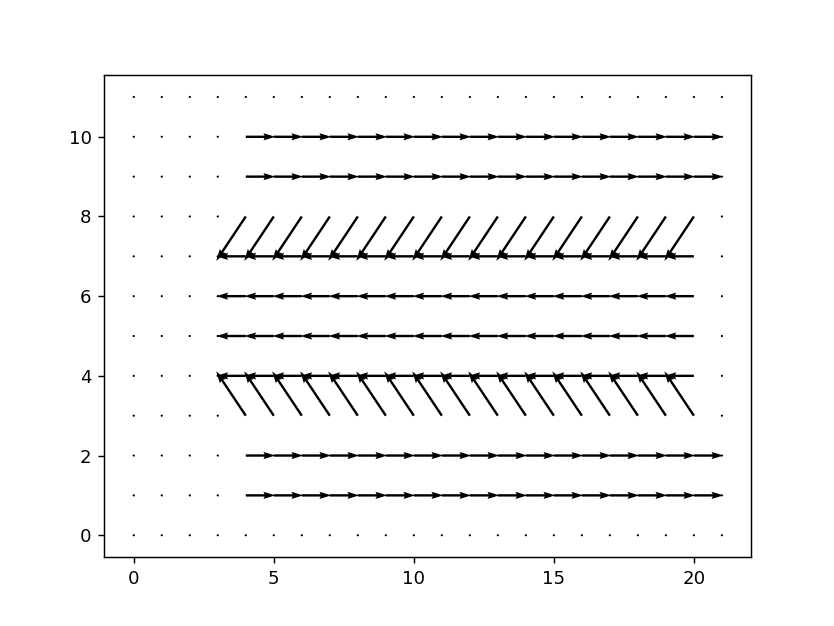

In [31]:
# (left-right),(down-up)

P_flux = np.array([P_out[:,:,3]-P_out[:,:,2],P_out[:,:,1]-P_out[:,:,0]])

plt.quiver(P_flux[1,:,:].T,P_flux[0,:,:].T)

In [21]:
P_flux[0,:,:].T.shape

(12, 22)

In [23]:
U.shape

(12, 22)